In [1]:
import os
import sys
import copy
import codecs
from glob import glob
from datetime import datetime
import random

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 12

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA = "../input/sleep-state"
PP_DATA = "../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz"
WINDOW_SIZE = 100
bs = 64

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ndsnr0rn
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ndsnr0rn
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101060 sha256=6b6a1874bbc8306ab782c5f4ec5e10ec9eece98d5055071d4c82b5bd71425ee8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozo9oqvy/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


In [6]:
import tensorflow as tf
print(tf.__version__)

2024-02-26 03:42:39.858998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 03:42:39.859121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 03:42:39.982366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [7]:
!pip install mne

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_auc_score, roc_curve

import mne
from mne.io import read_raw_edf

In [9]:
fnames = sorted(glob(os.path.join(PP_DATA, "*.npz")))

In [10]:
len(fnames)

39

In [11]:
fnames[0]

'../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz'

In [12]:
total_fs = [f for f in fnames if f.split("/")[-1][:5]]

In [13]:
len(total_fs), total_fs[0]

(39, '../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz')

In [14]:
total_data = {k: np.load(k) for k in total_fs}

In [15]:
samples = total_data["../input/eeg-fpz-cz/eeg_fpz_cz/eeg_fpz_cz/SC4001E0.npz"]

In [16]:
samples['x'].shape

(841, 3000, 1)

In [17]:
X = np.zeros((0, 3000, 1))
y = []
for fn in total_fs:
    samples = np.load(fn)
    X_data = samples["x"]
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples["y"])
y = np.array(y)

In [18]:
X.shape

(42308, 3000, 1)

In [19]:
y.shape

(42308,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42
)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=42
)

In [22]:
X_train.shape, X_test.shape, X_val.shape

((34269, 3000, 1), (4231, 3000, 1), (3808, 3000, 1))

In [23]:
def data_generator(X_samples, y_samples, bs=32, label=True):
    i = 0
#     X_samples = X_samples[:]
#     y_samples = y_samples[:]
    while True:
        X_temp = X_samples[i:i + bs]
        y_temp = y_samples[i:i + bs]
        
        X_temp = np.array([rescale_array(sample) for sample in X_temp])
        y_temp = np.array(y_temp)
        if label:
            yield X_temp, y_temp
        else:
            yield X_temp

        i += bs

In [24]:
Fs = 100

def DeepSleepNet(n_classes=5, use_sub_layer=False, summary=True):
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.shape
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.shape
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    if use_sub_layer:
        sub_layer = Dense(1024, activation="relu", name='sub_layer')(outLayer)
    # model = Model(inputLayer, mergeLayer)
    
    # LSTM
    outLayer = Reshape((1, int(fineShape[1]*fineShape[2] + coarseShape[1]*coarseShape[2])), name='reshape1')(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm1'))(outLayer)
    outLayer = Reshape((1, int(outLayer.shape[1])))(outLayer)
    outLayer = Bidirectional(LSTM(128, activation='relu', dropout=0.5, name='bLstm2'))(outLayer)
    
    # merge out_layer and sub_layer
    if use_sub_layer:
        outLayer = concatenate([outLayer, sub_layer], name='merge_2')
        outLayer = Dropout(rate=0.5, name='mDrop2')(outLayer)
        outLayer = Dense(256, activation="relu", name='sub_layer_2')(outLayer)
    outLayer = Dropout(rate=0.5, name='merge_out_sub')(outLayer)
    
    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    
    if summary:
        model.summary()

    return model

deepsleepnet = DeepSleepNet(use_sub_layer=False, summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inLayer (InputLayer)        [(None, 3000, 1)]            0         []                            
                                                                                                  
 fConv1 (Conv1D)             (None, 500, 64)              3264      ['inLayer[0][0]']             
                                                                                                  
 cConv1 (Conv1D)             (None, 60, 32)               12832     ['inLayer[0][0]']             
                                                                                                  
 fMaxP1 (MaxPooling1D)       (None, 62, 64)               0         ['fConv1[0][0]']              
                                                                                              

In [25]:
def evaluate_metrics(cm,classes):

    print ("Confusion matrix:")
    print (cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print ("Sample: {}".format(int(np.sum(cm))))
    n_classes = len(classes)
    for index_ in range(n_classes):
        print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV

In [26]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a
   
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [27]:
sample = X_train[0]

In [28]:
max(sample), min(sample)

(array([91.04615021]), array([-79.63516235]))

In [29]:
res = butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4)

In [30]:
max(res), min(res)

(array([0.43923789]), array([-0.38418737]))

In [31]:
checkpoint = ModelCheckpoint("model_cps.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor="val_loss", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
#     early,
    redonplat,
    csv_logger,
]

In [32]:
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

In [33]:
deepsleep = deepsleepnet.fit(
    X_train, y_train_, batch_size=64, epochs=50, validation_data=(X_val, y_val_), callbacks=callbacks_list
)

Epoch 1/50


I0000 00:00:1708919008.482142     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


536/536 [==============================] - ETA: 0s - loss: 1.5029 - acc: 0.3805
Epoch 1: val_loss improved from -inf to 1.43289, saving model to model_cps.keras
536/536 [==============================] - 24s 21ms/step - loss: 1.5029 - acc: 0.3805 - val_loss: 1.4329 - val_acc: 0.4391 - lr: 1.0000e-04
Epoch 2/50
534/536 [============================>.] - ETA: 0s - loss: 1.3323 - acc: 0.4556
Epoch 2: val_loss did not improve from 1.43289
536/536 [==============================] - 9s 17ms/step - loss: 1.3325 - acc: 0.4554 - val_loss: 1.2655 - val_acc: 0.4976 - lr: 1.0000e-04
Epoch 3/50
535/536 [============================>.] - ETA: 0s - loss: 1.1044 - acc: 0.5430
Epoch 3: val_loss did not improve from 1.43289
536/536 [==============================] - 9s 16ms/step - loss: 1.1042 - acc: 0.5431 - val_loss: 1.0796 - val_acc: 0.5465 - lr: 1.0000e-04
Epoch 4/50
535/536 [============================>.] - ETA: 0s - loss: 0.8049 - acc: 0.6888
Epoch 4: val_loss did not improve from 1.43289
536/536

In [34]:
y_pred = deepsleepnet.predict(X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

67/67 [==============================] - 1s 6ms/step
>>> f1 score: 0.6075673374106149
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       854
           1       0.00      0.00      0.00       278
           2       0.79      0.93      0.85      1769
           3       0.94      0.75      0.83       563
           4       0.52      0.80      0.63       767

    accuracy                           0.75      4231
   macro avg       0.64      0.61      0.61      4231
weighted avg       0.74      0.75      0.73      4231



In [35]:
deepsleepnet.save_weights("DeepSleepNet.h5")

In [36]:
accuracy_score(y_test, y_pred)

0.7501772630583786

In [39]:
deepsleep.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [41]:
import pickle

with open('deepsleep.pkl', 'wb') as file:
    pickle.dump(deepsleep.history, file)

Text(0, 0.5, 'loss')

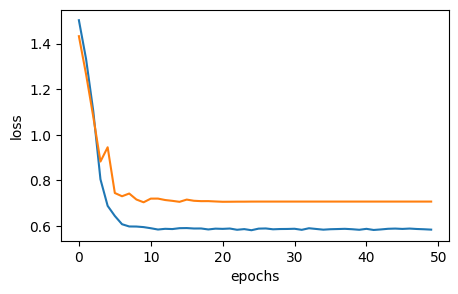

In [43]:
plt.figure(figsize=(5, 3))
plt.plot(deepsleep.history["loss"])
plt.plot(deepsleep.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

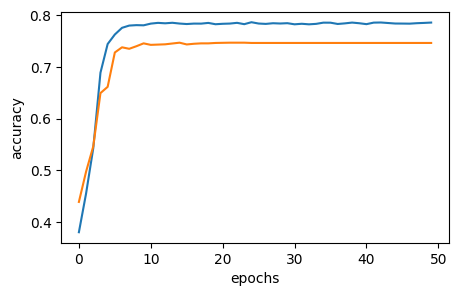

In [44]:
plt.figure(figsize=(5, 3))
plt.plot(deepsleep.history["acc"])
plt.plot(deepsleep.history["val_acc"])
plt.xlabel("epochs")
plt.ylabel("accuracy")

In [45]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])

In [46]:
pp_X_train.shape

(34269, 3000, 1)

In [48]:
deepsleep = DeepSleepNet()
hist2 = deepsleep.fit(
    pp_X_train, y_train_, batch_size=64, epochs=50, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inLayer (InputLayer)        [(None, 3000, 1)]            0         []                            
                                                                                                  
 fConv1 (Conv1D)             (None, 500, 64)              3264      ['inLayer[0][0]']             
                                                                                                  
 cConv1 (Conv1D)             (None, 60, 32)               12832     ['inLayer[0][0]']             
                                                                                                  
 fMaxP1 (MaxPooling1D)       (None, 62, 64)               0         ['fConv1[0][0]']              
                                                                                            

In [50]:
y_pred = deepsleep.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)


67/67 [==============================] - 0s 3ms/step
>>> f1 score: 0.712388735616362
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       854
           1       0.56      0.13      0.21       278
           2       0.92      0.82      0.87      1769
           3       0.84      0.93      0.88       563
           4       0.62      0.84      0.71       767

    accuracy                           0.81      4231
   macro avg       0.76      0.73      0.71      4231
weighted avg       0.82      0.81      0.80      4231



67/67 [==============================] - 0s 5ms/step
>>> Confusion Matrix:


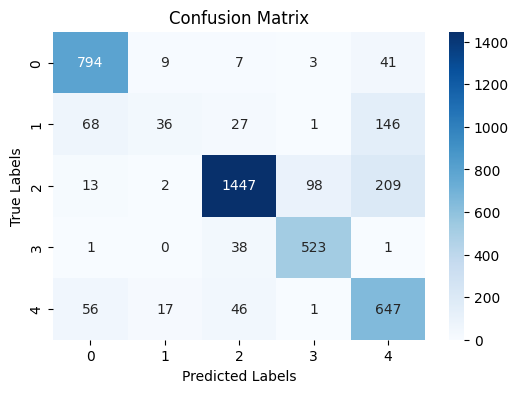

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = deepsleep.predict(pp_X_test, batch_size=bs)
y_pred = np.array([np.argmax(s) for s in y_pred])
conf_matrix = confusion_matrix(y_test, y_pred)
print(">>> Confusion Matrix:")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [52]:
accuracy_score(y_test, y_pred)

0.8147010163082014

Text(0, 0.5, 'Loss')

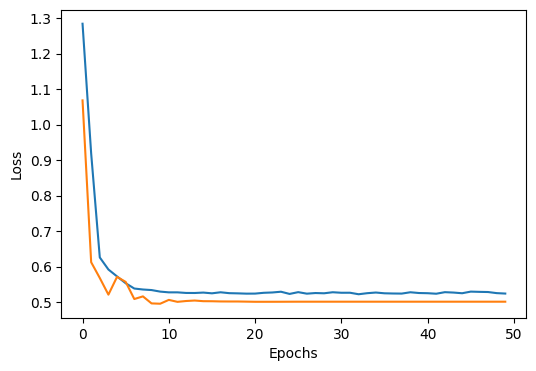

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

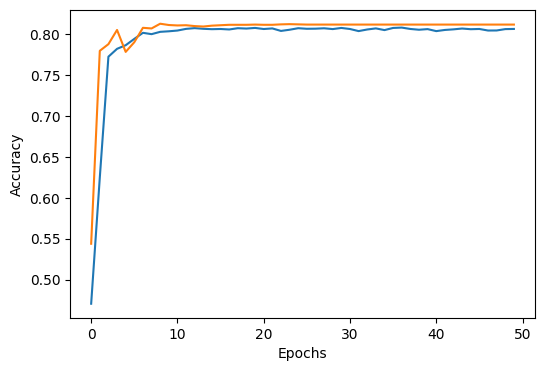

In [54]:
plt.figure(figsize=(6, 4))
plt.plot(hist2.history["acc"])
plt.plot(hist2.history["val_acc"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [55]:
deepsleep.save_weights("deepsleepnet.h5")

In [56]:
model_json = deepsleep.to_json()
with open("eeg_model_2019_config.json", "w") as f:
    f.write(model_json)

In [57]:
!ls log_training.csv

log_training.csv
